# Causal Discovery example on the Lalonde dataset

Here we study the twins dataset as studied by <a href="https://arxiv.org/pdf/1705.08821.pdf" target="_blank">Louizos et al</a>. We focus on twins which are the same sex and weigh less than 2kgs. The treatment t = 1 is being born the heavier twin and the outcome is mortality of each of the twins in their first year of life.The confounding variable taken is 'gestat10', the number of gestational weeks prior to birth, as it is highly correlated with the outcome. The results using the methods below are in coherence with those obtained in the paper. 



In [1]:
# import os
# os.environ['PATH'] += os.pathsep + 'C:\Program Files\Graphviz\bin\dot.exe'

import dowhy
from dowhy import CausalModel
from rpy2.robjects import r as R
%load_ext rpy2.ipython

# %R install.packages("Matching")
%R library(Matching)

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_prior_knowledge

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

R[write to console]: Loading required package: MASS

R[write to console]: ## 
##  Matching (Version 4.9-9, Build Date: 2021-03-15)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##


['1.19.5', '1.1.5', '0.16', '1.5.2']


## 1. Load the data

In [3]:
%R data(lalonde)
%R -o lalonde
lalonde = lalonde.astype({'treat':'bool'}, copy=False)
lalonde

,age,educ,black,hisp,married,nodegr,re74,re75,re78,u74,u75,treat
1,37,11,1,0,1,1,0.00,0.0,9930.05,1,1,True
2,22,9,0,1,0,1,0.00,0.0,3595.89,1,1,True
3,30,12,1,0,0,0,0.00,0.0,24909.50,1,1,True
4,27,11,1,0,0,1,0.00,0.0,7506.15,1,1,True
5,33,8,1,0,0,1,0.00,0.0,289.79,1,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
441,21,9,1,0,0,1,31886.40,12357.2,0.00,0,0,False
442,28,11,1,0,0,1,17491.50,13371.3,0.00,0,0,False
443,29,9,0,1,0,1,9594.31,16341.2,16900.30,0,0,False
444,25,9,1,0,1,1,24731.60,16946.6,7343.96,0,0,False


## Utility function
We define a utility function to draw the directed acyclic graph.

In [2]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

# Causal Discovery

To run causal discovery, we create a DirectLiNGAM object and call the fit method.

<class 'str'>
digraph {
	age
	educ
	black
	hisp
	married
	nodegr
	re74
	re75
	re78
	u74
	u75
	treat
	married -> age [label=1.89]
	nodegr -> educ [label=-2.33]
	hisp -> black [label=-0.91]
	u74 -> re74 [label=-6674.32]
	married -> re75 [label=854.41]
	re74 -> re75 [label=0.24]
	u75 -> re75 [label=-2030.49]
	u74 -> u75 [label=0.71]
	nodegr -> treat [label=-0.08]
}


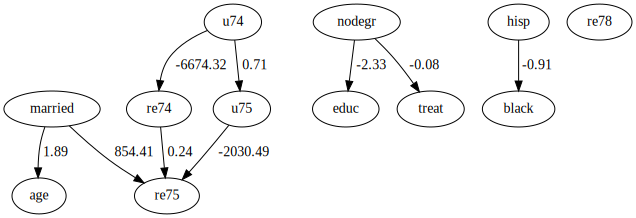

In [7]:
# pk = make_prior_knowledge(
#     n_variables=len(lalonde.columns),
#     sink_variables=[11])
# model = lingam.DirectLiNGAM(prior_knowledge=pk)
# model.fit(lalonde)

model = lingam.ICALiNGAM()
d = model.fit(lalonde)
# print(d)

# print(model.adjacency_matrix_)
labels = [f'{col}' for i, col in enumerate(lalonde.columns)]
graph_dot = make_graph(model.adjacency_matrix_, labels)
print(type(graph_dot.source))
print(graph_dot.source)
graph_dot

## Run DoWhy analysis: model, identify, estimate

In [16]:
graph = graph_dot.source.replace('\n', ';').replace('\t','')
graph = graph[:9] + graph[10:-2] + graph[-1]
print(graph)

# graph = "digraph {a -> b [label=1.89]; a -> c [label=-2.33]}"

# model=CausalModel(
#         data = lalonde,
#         treatment='a',
#         outcome='c',
#         graph=graph)

model=CausalModel(
        data = lalonde,
        treatment='treat',
        outcome='re78',
        graph=graph)#_dot.source)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# estimate = model.estimate_effect(identified_estimand,
#         method_name="backdoor.propensity_score_weighting",
#         method_params={"weighting_scheme":"ips_weight"})
#print(estimate)
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                control_value=0,
                                treatment_value=1,
                                confidence_intervals=True,
                                test_significance=True)

print("Causal Estimate is " + str(estimate.value))

digraph {age;educ;black;hisp;married;nodegr;re74;re75;re78;u74;u75;treat;married -> age [label=1.89];nodegr -> educ [label=-2.33];hisp -> black [label=-0.91];u74 -> re74 [label=-6674.32];married -> re75 [label=854.41];re74 -> re75 [label=0.24];u75 -> re75 [label=-2030.49];u74 -> u75 [label=0.71];nodegr -> treat [label=-0.08]}
Causal Estimate is 1794.3430848752596
